##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

%matplotlib notebook

# %matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass



from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD','fco2':'fco2',
        'Out_of_Basin':'OOB',#'F$_{out}$',
        'Upland':'Upland',#'F$_{up}$',
        'Sedge':'Sedge',#'F$_{sdg}$',
        'Shrub':'Shrub',#'F$_{shb}$',
        'Sparse':'Sparse',#'F$_{spr}$',
        'Grass':'Grass',#'F$_{grs}$',
        'Temp':'T$_{s}$','H':'$H$','VPD':'VPD','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'AirTC_Avg':'T$_{a}$','air_pressure':'P$_{a}$',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$','(z-d)/L':'Stability'}

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
Site='Illisarvik'

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [387]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def MapJobs(target,Range,N,Mask={},map_range=None):
    target.Project(Projector = None,Model = None)
    columns=[Range]
    l = 1
    for key in Mask.keys():
        columns.append(key)  
        l+=1
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    try:

        scaler = StandardScaler()
        scaler.fit(target.RST.Data[columns[l:]])
        Temp = scaler.transform(target.RST.Data[columns[l:]])
        Temp = pd.DataFrame(data = Temp,columns = columns[l:])
        kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
#         print(kmeans)
#         print(Temp)
        Q = scaler.inverse_transform(kmeans.cluster_centers_)
    except:
        Q = []
        for col in columns[1:]:
            Q.append(Mask[col])
        Q=np.asanyarray(Q).T
        pass
    columns.append('target')
    def Make(Data,columns,map_range,values,C=20,Mask=None,i=0):
        ranges = [np.linspace(map_range[0],map_range[1],C)]
        for key in Mask.keys():
            ranges.append(np.ones(C)*Mask[key])
        for v in values:
            ranges.append(np.ones(C)*v)
        ranges.append(np.ones(C)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        data['key']=i
        
        return(pd.DataFrame(data = data))
    tarList=[]
    if map_range is None:
        map_range = [target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()]
    if len(Q) == 0:
        Data = Make(target.RST.Data,columns,
                    map_range=map_range,
                    values=[],Mask={key:item[i] for key, item in Mask.items()})
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
            
        if i == 0:
            Data = Make(target.RST.Data,columns,
                    map_range=map_range,values=values,C=30,
                    Mask={key:item[i] for key, item in Mask.items()})
        else:
            Data = Data.append(Make(target.RST.Data,columns,
                    map_range=map_range,values=values,C=30,
                    Mask={key:item[i] for key, item in Mask.items()},i=i))
            
    target.RST.Data=Data
    target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
    target.Map()
    tarList.append(target.Data_Map)  
    return(tarList,Q,columns[1:-1],Data)


In [3]:
def Performance(ax,title,target,verbose):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
           yerr=target.level_best['SE'].values*target.SE_Rule,
           color='grey',
        alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.SE_Rule,
           color='red',
           alpha = 1,
           label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.SE_Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
#     ax.set_ylabel('MSE')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.SE_Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.SE_Rule])
    plt.sca(ax)
    plt.grid()
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,SE_Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
        print(Best.sort_values(by='MSE'))
    else:
        alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
#         print(Best)
        print()
        print(Data.sort_values(by='MSE'))
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
#         print()
    ax.grid()

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],
                       target.params['Inputs'],
                       ScalePath=target.params['Spath'],
                       Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],
                   target.params['Inputs'],
                   ScalePath=target.params['Spath'],
                   Project=True,
                   fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)


def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)


In [4]:
class ResultMap:
    def __init__(self,target,Test='T',SE_Rule=1,alpha = .025,AltPath=None):
        self.SE_Rule = SE_Rule
        self.target = target        
        self.params = Dense.Params('Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += self.target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Records['SE']
        Names = []
        rem = []
        for level in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==level]
#             print(Level)
            if level == 1:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append(aliases[LastMod[0]])
            elif level == 99:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append('N/A')
            else:
                level_best = level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                Mod = level_best.loc[level_best['Size']==level,'Model'].values[0].split('+')

        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.level_best = level_best
        
        self.Records['T2']=0
        self.Records['Performance'] = 0
        for j in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==j]
            ##T-test
            if Test == 'T':
                Sv = (((Level['SE']**2+self.Min['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-self.Min['MSE'].values[0])/(Sv*(2/self.params['K'])**.5)

                Level.loc[Level['T2'].abs()<=stats.t.ppf(1-alpha,self.params['K']),'Performance']+=1
#                 print(Level[['Model','T2']])
            ##SE-Rule
            else:
                Test == 'SE'
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0]+self.Min['SE'].values[0]*SE_Rule,'Performance']+=1
            self.Records.loc[self.Records['Size']==j]=Level
        
            Trecords = self.Records.loc[self.Records['Performance']==self.Records['Performance'].max()]
            self.Best = (Trecords.loc[Trecords['Size']==Trecords['Size'].min()])
            self.Model_Selection = self.Best.loc[self.Best['MSE'] == self.Best['MSE'].min(), 'Model'].values[0]
                
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
#         print()
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
#         idx = '99_99'
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
#             for k in range(self.params['K']):
#                 results=Dense.Load_Model(k,X=X,params=self.params)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.params['K']))):
                prog1.value+=1
                Y = results
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
        
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
#         plt.figure()
        YTru = self.RST.y+0.0
#         plt.scatter(Y_fill_bar,self.RST.y)
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        
        YVar = Dense.Load_Model(i=1,X=X,params=self.params)
#             YVar = results
        YVar = self.RST.YvarScaled.inverse_transform(YVar) 
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(1,2))):
            YVar = results
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                    
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        
#         print(X_back)
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            print(self.Data_Map.shape,self.RST.Data['key'].shape)
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        
#         if Imputate == True:
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
     

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



   index                                Model       MSE  Size  Number  \
0     25    wind_speed+PPFD_Avg+VPD+VWC+Shrub  1.221099     5       0   
1     30  PPFD_Avg+VPD+VWC+Shrub+Out_of_Basin  1.223544     5       5   
2     27          PPFD_Avg+VPD+Temp+VWC+Shrub  1.227724     5       2   
3     26     PPFD_Avg+AirTC_Avg+VPD+VWC+Shrub  1.251529     5       1   
4     28         PPFD_Avg+VPD+VWC+Sedge+Shrub  1.285469     5       3   
5     29         PPFD_Avg+VPD+VWC+Shrub+Grass  1.290662     5       4   

         SE  Performance Model_Key      RMSE  T2  
0  0.213472            1       5_0  1.105033   0  
1  0.183680            1       5_5  1.106139   0  
2  0.170491            1       5_2  1.108027   0  
3  0.126142            1       5_1  1.118718   0  
4  0.170888            1       5_3  1.133785   0  
5  0.159524            1       5_4  1.136073   0  


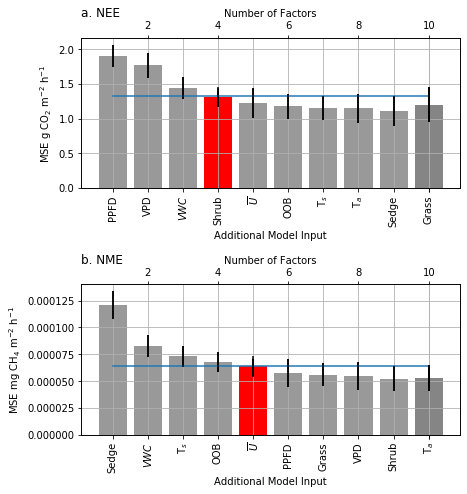

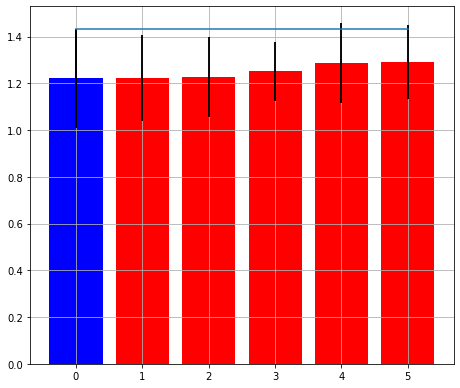

In [5]:

fco2 = ResultMap('fco2',Test='SE',SE_Rule=1)
fch4 = ResultMap('fch4',Test='SE',SE_Rule=1)
ER = ResultMap('ER',Test='SE',SE_Rule=1,AltPath='fco2')
fco2_fixed = ResultMap('fco2',Test='SE',SE_Rule=1)
fch4_fixed = ResultMap('fch4',Test='SE',SE_Rule=1)
ER_fixed = ResultMap('ER',Test='SE',SE_Rule=1,AltPath='fco2')


fig,ax=plt.subplots(2,1,figsize=(6.5,7))
Performance(ax[0],'a. NEE',fco2,verbose = 0)
Performance(ax[1],'b. NME',fch4,verbose = 0)
ax[0].set_ylabel('MSE g CO$_2$ m$^{-2}$ h$^{-1}$')
ax[1].set_ylabel('MSE mg CH$_4$ m$^{-2}$ h$^{-1}$')

plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Appendix1.png',dpi=300)


fig,ax=plt.subplots(1,1,figsize=(6.5,5.5))
LevelPerformance(ax,'a. fco2',fco2,level=5)
# LevelPerformance(ax[1],'b. fch4',fch4,level=2)
plt.tight_layout()



In [6]:
# print(ER.Records)

In [90]:
T30 = ER.RST.Master.loc[ER.RST.Master['fco2']>0]
T30 = fco2.RST.Master.copy()

T30['VWC'].loc[T30['VWC']<.5]=np.nan
T30['VWC']=T30['VWC'].interpolate()

T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
T30[['Sedge','Shrub','Grass','Upland']]=T30[['Sedge','Shrub','Grass','Upland']].interpolate()

T30_Dark = T30.copy()
T30_Fixed = T30.copy()
T30_Dark['PPFD_Avg']=T30['PPFD_Avg'].min()
# T30 = T30BU.copy()
FPRatios = {'Sedge':.153961,
            'Sparse':.083902,
            'Shrub':.482874,
            'Grass':.279263,
            'Upland':0.0,
            'Out_of_Basin':0.0
}


# FPRatios = {'Sedge':1,
#             'Sparse':.0,
#             'Shrub':1,
#             'Grass':.0,
#             'Upland':0.0,
#             'Out_of_Basin':0
# }


for var in ['Sedge','Sparse','Shrub','Grass','Upland','Out_of_Basin']:
    T30_Fixed[var] = FPRatios[var]
T30_Dark_Fixed = T30_Fixed.copy()
T30_Dark_Fixed['PPFD_Avg']=T30['PPFD_Avg'].min()

T30 = Mapper(T30,fco2,'NEE_est',Fill = False)
print('NEE_est')

T30 = Mapper(T30,fch4,'NME_est',Fill = False)
print('NME_est')

T30 = Mapper(T30,ER,'ER_est',Fill = False,DarkTarget=T30_Dark)
print('ER_est')

T30 = Mapper(T30,ER_fixed,'ER_fixed_est',Fill = False,DarkTarget=T30_Dark_Fixed)
print('ER_fixed_est')

T30 = Mapper(T30,fco2_fixed,'NEE_fixed_est',Fill = False,DarkTarget=T30_Fixed)
print('NEE_fixed_est')

T30 = Mapper(T30,fch4_fixed,'NME_fixed_est',Fill = False,DarkTarget=T30_Fixed)
print('NME_fixed_est')

# T30 = Mapper(T30,Test,'NME_fixed_est',Fill = False,DarkTarget=T30_Fixed)
# print('NME_fixed_est')

T30BU = T30.copy()

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


FloatProgress(value=0.0, description='Running:', max=30.0)

NEE_est


FloatProgress(value=0.0, description='Running:', max=30.0)

NME_est


FloatProgress(value=0.0, description='Running:', max=30.0)

ER_est


FloatProgress(value=0.0, description='Running:', max=30.0)

ER_fixed_est


FloatProgress(value=0.0, description='Running:', max=30.0)

NEE_fixed_est


FloatProgress(value=0.0, description='Running:', max=30.0)

NME_fixed_est


In [8]:
# print(Test.Records['Model_Key'])
# print(Test.Records['Model'])
# print(Test.Model)

In [166]:
# G-C.c=
T30 = T30BU.copy()
mult = {'fco2':(1e-6 * 12.0107 *1800),
        'ER':(1e-6 * 12.0107 *1800),
        'fch4':(1e-3 * 12.0107 *1800)}
# G-CO2/CH4
# mult = {'fco2':1e-6 * 44.0095 *3600*24,
#         'fch4':1e-3 * 16.04246 *3600*24}
# mult = {'fco2':1,
#         'fch4':1}
for target,name in zip([fch4,fco2,ER],['NME','NEE','ER']):
#     print(T30.shape,target.Y_fill.shape)
    target.cols = []
    print(name)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')


for target,name in zip([fch4,fco2,ER],['NME_est','NEE_est','ER_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]*mult[target.target]
#         B = target.RST.Master[target.target].fillna(T30['Fill'])
#         T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')


for target,name in zip([fch4_fixed,fco2_fixed,ER_fixed],['NME_fixed_est','NEE_fixed_est','ER_fixed_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]*mult[target.target]
#         B = target.RST.Master[target.target].fillna(T30['Fill'])
#         T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')


NME
NEE
ER
Done
Done
Done


<IPython.core.display.Javascript object>


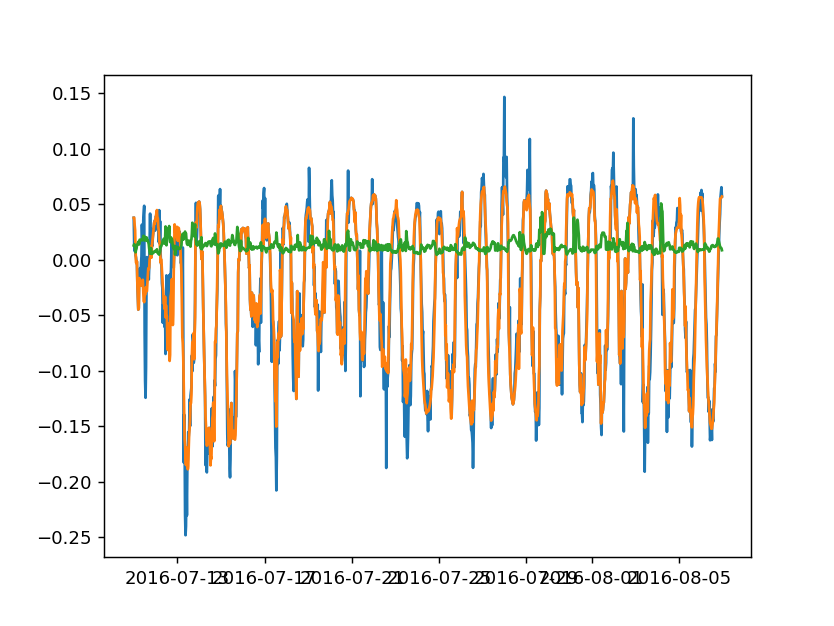

In [231]:
# print(ER.target)
plt.figure()
# plt.plot(T30['ER'])
# plt.plot(T30['ER_1'])
plt.plot(T30['NEE'])
plt.plot(T30['NEE_est'])
plt.plot(T30['NEE_est_Var_reg']**.5*mult[fco2.target]*stats.t.ppf(1-.025,30))

In [328]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)

mult = {'fco2':(1e-6 * 12.0107 *1800),
        'ER':(1e-6 * 12.0107 *1800),
        'fch4':(1e-3 * 12.0107 *1800)}

Temp = T30.copy()
Estimates = []
CIs = []
SE = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
Targets = {'NEE':fco2,
           'ER':ER,
           'NME':fch4,
           'NEE_est':fco2,
           'ER_est':ER,
           'NME_est':fch4,
           'NEE_fixed_est':fco2_fixed,
           'ER_fixed_est':ER_fixed,
           'NME_fixed_est':fch4_fixed}
for Var in ['NEE','NEE_fixed_est','ER_est','ER_fixed_est','NME','NME_fixed_est']:#,
    target = Targets[Var]
#     Temp[target.cols]*=mult[target.target]
    if Var == 'NEE' or Var == 'NME' or Var == 'ER':
        CIPI = 'CI'
        Fluxes.append(Var.split('_')[0])
        Type.append('EC Obs.')
        std = MI(Temp,target.cols)**.5#,Var,n=30)
        print((std/Temp.shape[0]**.5)*48*stats.t.ppf(1-.025,Temp[Var].count()))
        Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())*48#*mult[target.target]
#         SE.append(std**.5*48)
#         print(pooled_std)
    else:
        Fluxes.append(Var.split('_')[0])
        CIPI = 'CI'
        Type.append('EC Obs.')
        std = (Temp[Var+'_Var_reg']).mean()**.5*mult[target.target]*48
        Int=((std)/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())*48#*mult[target.target
    SE.append(std)
#       
#     else:
#         Fluxes.append(Var.split('_')[0])
#         CIPI = 'PI'
#         Type.append('NN est.')
#         if Var == 'ER':
#             Var = 'ER_est'
#         pooled_std = ((Temp[Var+'_Var_reg']+Temp[Var+'_Var_er'])).mean()**.5*mult[target.target]
#         Int=(1/Temp.shape[1])**.5*pooled_std*stats.t.ppf(1-.025,Temp[Var].count()-30)#))
    U = Temp[Var].sum()/(Temp.shape[0]/48)#*mult[target.target]
    Estimates.append(U)
    CIs.append(Int)
    
    if Var.split('_')[-1]=='fixed':
        Scale.append('Basin')
    elif len(Var.split('_'))>1:
        if Var.split('_')[1]=='fixed':#len(Var.split('_'))<2:
            Scale.append('Basin')
        else:
            Scale.append('Footprint')
    else:
        Scale.append('Footprint')
    
    Samples.append(Temp[Var].count())
    IntType.append(CIPI)
           
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
# print(Data)
Res = pd.DataFrame(data = Data)
# print(Res)
Cres = pd.read_csv('C:\\Users\\wesle\\Illisarvik_Processing/ScaledChamberFluxes.csv',
                   index_col=[0],delimiter = ',')
                   
# print(Cres)

All = Res.append(Cres).sort_values('Flux').reset_index(drop=True)
# Tem = (All.loc[All['Type'] == 'NN est.'])
Tem = (All.loc[((All['Type'] == 'NN est.')|(All['Type'] == 'EC Obs.'))])
# print(Tem)
CO2=(Tem.loc[Tem['Flux'] == 'NEE','Estimates']).values[0]
CH4=(Tem.loc[Tem['Flux'] == 'NME','Estimates']).values[0] #*28*1e-3

print(All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']])

# print(Temp['NEE'].mean(),Temp['NEE'].std()/Temp['NEE'].count()**.5*stats.t.ppf(1-.05,Temp['NEE'].count()))

print('ER %',(4.421518-2.297091)/4.421518)
print('NEM %',(12.906349-9.001876)/12.906349)


print(H1[['GPP','ER','NEE','NME']].mean()*48)
print(H1[['GPP','ER','NEE','NME']].min()*48)
print(H1[['GPP','ER','NEE','NME']].max()*48)

0.17747920812511198
0.49063480827254596
  Flux          Type      Scale  Estimates        SE  95% CI/PI
0   ER       EC Obs.  Footprint   2.279725  0.454437   1.188683
1   ER       EC Obs.      Basin   2.378956  0.502659   1.314820
2   ER  Chamber Obs.  Footprint   4.421518  0.417377   0.830404
3   ER  Chamber Obs.      Basin   4.008449  0.421306   0.840870
4  NEE       EC Obs.  Footprint  -1.547864  0.067851   0.177479
5  NEE       EC Obs.      Basin  -1.395767  0.362374   0.947871
6  NME       EC Obs.  Footprint   9.001876  0.187571   0.490635
7  NME       EC Obs.      Basin  11.448464  5.787227  15.137812
8  NME  Chamber Obs.  Footprint  12.906349  3.796330   7.553098
9  NME  Chamber Obs.      Basin  14.968051  4.331294   8.644676
ER % 0.4804745790925198
NEM % 0.3025234324594818
GPP    3.844955
ER     2.297091
NEE   -1.547864
NME    9.001876
dtype: float64
GPP    1.991238
ER     1.228814
NEE   -3.634057
NME    1.928520
dtype: float64
GPP     5.173891
ER      3.175649
NEE     0.21474

<IPython.core.display.Javascript object>


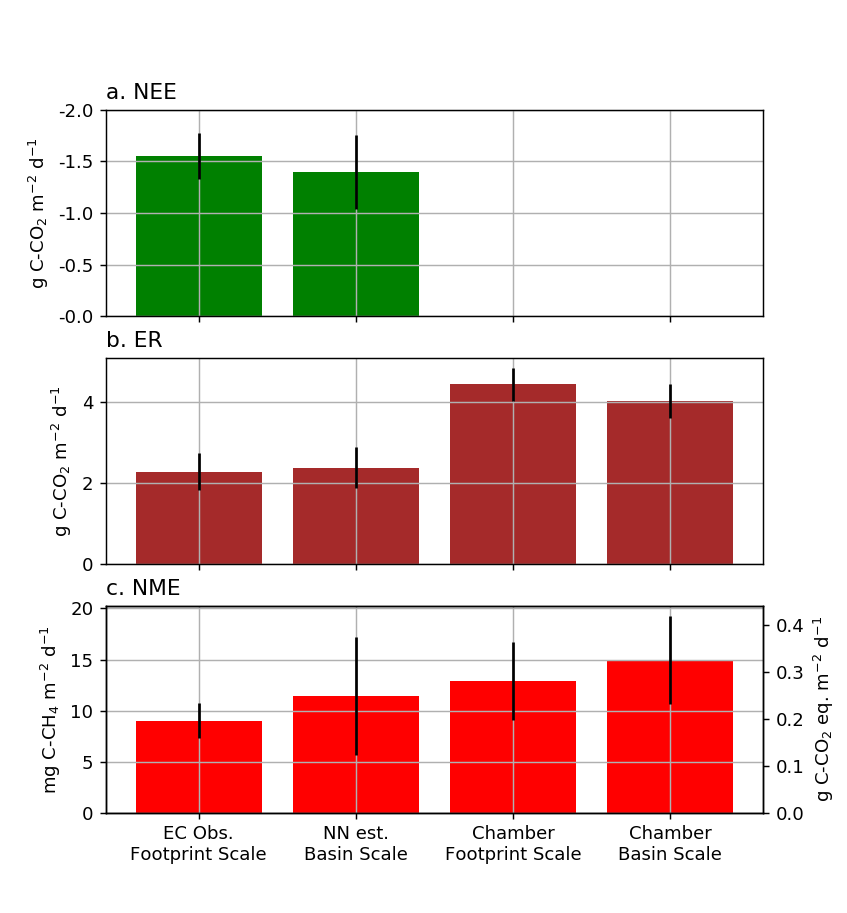

In [192]:
fig,ax = plt.subplots(2,1,figsize = (6.5,7),sharex=True)


ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0))#, rowspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0))
Labels =['EC Obs.\nFootprint Scale','NN est.\nBasin Scale','Chamber\nFootprint Scale','Chamber\nBasin Scale']
ax1.bar([0,1],All.loc[All['Flux']=='NEE','Estimates']*-1,
        yerr = All.loc[All['Flux']=='NEE','SE'],color='green',label='NEE')

ax2.bar([0,1,2,3],All.loc[All['Flux']=='ER','Estimates'],
        yerr = All.loc[All['Flux']=='ER','SE'],color='brown',label='ER')

Conv = 28*1e-3
ax3_2=ax3.twinx()
ax3.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates'],
        yerr = All.loc[All['Flux']=='NME','SE'],color='red',label='NME')
ax3_2.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates']*Conv,color='None',label='')



ax3.set_xticks([0,1,2,3])
ax1.set_xticks([0,1,2,3])
ax1.set_xlim(ax2.get_xlim())
yt = ax1.get_yticks()
ax1.set_yticks(yt)
ax1.set_yticklabels(yt*-1)
ax2.set_xticks([0,1,2,3])
ax3.set_xticklabels(Labels)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
# ax1.legend(loc=4)
# ax2.legend(loc=2)
ax1.grid()
ax2.grid()
ax1.set_title('a. NEE',loc='left')
ax1.set_ylabel('g C-CO$_2$ m$^{-2}$ d$^{-1}$')
ax2.set_title('b. ER',loc='left')
ax2.set_ylabel('g C-CO$_2$ m$^{-2}$ d$^{-1}$')
# ax3.legend(loc=2)
ax3.grid()
ax3.set_title('c. NME',loc='left')
ax3.set_ylabel('mg C-CH$_4$ m$^{-2}$ d$^{-1}$')
ax3_2.set_ylabel('g C-CO$_2$ eq. m$^{-2}$ d$^{-1}$')
# ax3.bar([2,3],[0,0],
#         color='None')
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig11.png')  

In [300]:


T30['GPP'] = -1*T30['NEE']+T30['ER']
T30['GPP_fixed'] = -1*T30['NEE_fixed_est']+T30['ER_fixed_est']


T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
HafHourly = T30.resample('D').mean()
# v='NEE'

HafHourly['Rain_mm_Tot'] = T30['Rain_mm_Tot'].resample('D').sum()
HafHourlys = T30.resample('D').std()
for target,v in zip([ER,fco2,fch4],['ER','NEE','NME']):
#     HafHourly[v+'Pooled_CI'] = 0
#     HafHourly[v+'Pooled_PI'] = 0
    for day in HafHourly.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
#         if v
#         pooled_std = 
        HafHourly.loc[HafHourly.index==day,v+'_Var']=MI(Samp,target.cols,JustBetween=True)*48#/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])
#         HafHourly.loc[HafHourly.index==day,v+'_Std']=pooled_std#*((1/Samp.shape[0]+1/T30.shape[0])**.5)*stats.t.ppf(1-.025,Samp.shape[0])

for target,v in zip([ER,fco2,fch4],['ER_est','NEE_est','NME_est']):
    for day in HafHourly.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
        HafHourly.loc[HafHourly.index==day,v+'_Var']=(Samp[v+'_Var_reg']).mean()**.5*mult[target.target]#*48
    

Daily = T30.resample('D').sum()
# Daily['ER_Sum'] = HafHourly['ER']+0
Daily['ER_CI'] = (HafHourly['ER_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['ER_est_CI'] = (HafHourly['ER_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NEE_CI'] = (HafHourly['NEE_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NEE_est_CI'] = (HafHourly['NEE_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NME_CI'] = (HafHourly['NME_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NME_est_CI'] = (HafHourly['NME_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
print(Daily[['ER_CI','ER_est_CI']])
# print(HafHourly['NEE_est_Var']/(48**.5)*stats.t.ppf(1-.025,48)*48)
# print(Daily[['ER','ER_CI']])
# print(HafHourly)*

               ER_CI  ER_est_CI
datetime                       
2016-07-11  0.080006   0.075982
2016-07-12  0.073779   0.084934
2016-07-13  0.213055   0.257549
2016-07-14  0.187856   0.202751
2016-07-15  0.185427   0.202478
2016-07-16  0.102993   0.094299
2016-07-17  0.092377   0.097735
2016-07-18  0.100118   0.097128
2016-07-19  0.133889   0.121969
2016-07-20  0.091567   0.094285
2016-07-21  0.074374   0.095398
2016-07-22  0.067535   0.074379
2016-07-23  0.042889   0.062875
2016-07-24  0.113277   0.111423
2016-07-25  0.060453   0.062677
2016-07-26  0.107227   0.121238
2016-07-27  0.179143   0.185625
2016-07-28  0.204494   0.207973
2016-07-29  0.119344   0.140404
2016-07-30  0.094925   0.112722
2016-07-31  0.109983   0.131549
2016-08-01  0.131669   0.146685
2016-08-02  0.093147   0.109001
2016-08-03  0.067135   0.073347
2016-08-04  0.088019   0.123240
2016-08-05  0.061210   0.079113
2016-08-06  0.135888   0.138755


In [78]:
# mult = 1#24
# print('Cbal', 24*(T30['NEE'].mean()*mult+T30['NME'].mean()*mult*1e-3*28))
# print('Cbal', T30['NEE_fixed_est'].mean()*mult+T30['NME_fixed_est'].mean()*mult*1e-3*28)

# print(H2['NEE']/48)
# print(H1['NEE'])
# print(T30['Temp'])
print(T30['AirTC_Avg'].mean())
print(T30['Temp'].mean())

9.549784850823036
7.226713188976386


<IPython.core.display.Javascript object>


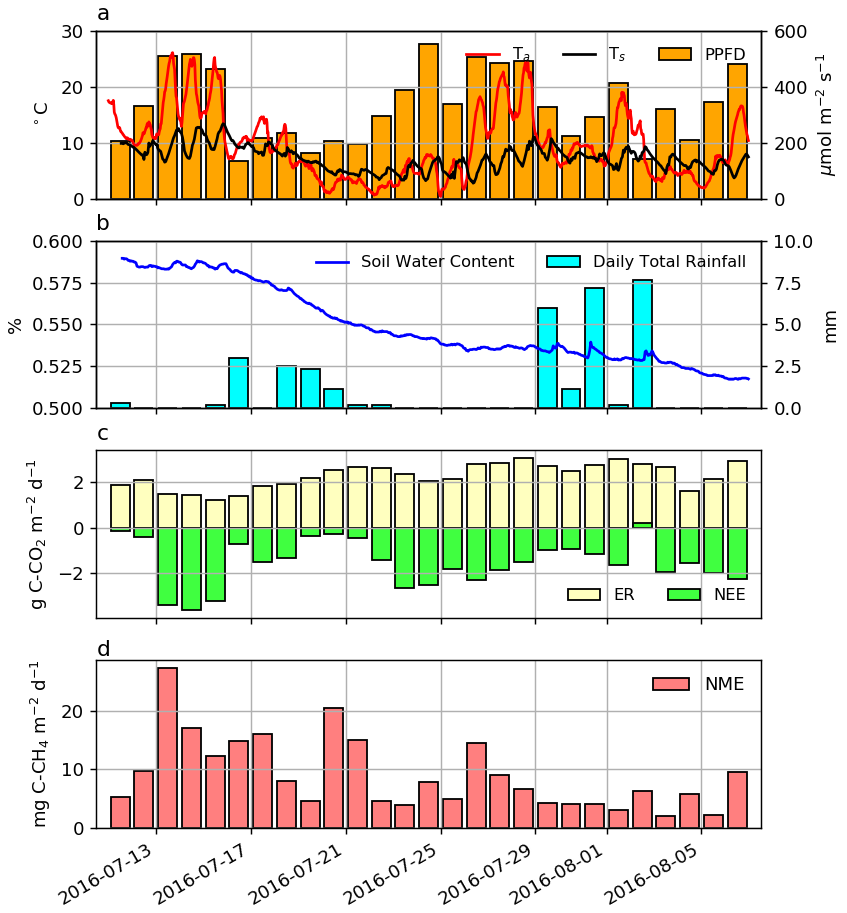

In [323]:
fig,ax = plt.subplots(4,1,figsize = (6.5,7),sharex=True)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'T$_a$')
ax[0].plot(T30['Temp'],color='black',label = 'T$_s$')
ax[0].bar(T30.index,T30['PPFD_Avg']*np.nan,facecolor='orange',edgecolor='black',label = 'PPFD')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
yax2.bar(HafHourly.index+datetime.timedelta(hours=12),HafHourly['PPFD_Avg'],
         facecolor='orange',edgecolor='black',label = 'PPFD')
yax2.set_ylim(0,600)

ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend(ncol = 3,fontsize=9,loc=0,facecolor='None',edgecolor='None')
ax[0].set_title('a',loc='left')

yax2 = ax[1].twinx()
yax2.bar(Daily.index+datetime.timedelta(hours=12),Daily['Rain_mm_Tot'],
         facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
# ax[1].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,label = 'Daily Total Rainfall')
yax2.set_ylim(0,10)

ax[1].plot(T30['VWC'],color='blue',label = 'Soil Water Content')
# ax[1].plot(fco2.RST.Master['VWC'],color='orange',label = 'Soil Water Content')
ax[1].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
ax[1].set_ylim(.50,.6)
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('mm')
ax[1].set_ylabel('%')
ax[1].set_title('b',loc='left')
ax[1].legend(ncol=2,fontsize=9,facecolor='None',edgecolor='None')

ax[0].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[1].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])

ax[2].bar(Daily.index+datetime.timedelta(hours=12),Daily['ER_est'],
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          edgecolor = 'black',facecolor=[1,1,.5,.5],label='ER')
ax[2].bar(Daily.index+datetime.timedelta(hours=12),Daily['NEE'],
          edgecolor = 'black',facecolor=[0,1,0,.75],
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label='NEE')

ax[2].grid()
ax[2].set_title('c',loc='left')
# ax[2].text(datetime.datetime(2016, 7, 11, 0),2.8,'c.')
ax[2].set_ylabel('g C-CO$_2$ m$^{-2}$ d$^{-1}$')#${\mu}$mol
ax[2].legend(fontsize=9,#bbox_to_anchor=(0, -.052, 0.5, .1),
             facecolor='None',
             edgecolor='None',
             ncol=2,loc=0)

ax[2].set_xticklabels([])


ax[3].bar(Daily.index+datetime.timedelta(hours=12),Daily['NME'],
          edgecolor = 'black',facecolor=[1,0,0,.5],
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label ='NME')
ax[3].grid()
ax[3].set_title('d',loc='left',pad = -.3)
ax[3].set_ylabel('mg C-CH$_4$ m$^{-2}$ d$^{-1}$')#nmol

ax[2].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[3].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[3].legend(facecolor='None',edgecolor='None')
fig.autofmt_xdate()
plt.tight_layout(pad=0.25)

# plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig3.png',dpi=300)

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig2.png',dpi=300)

In [313]:
# Dailys = Dailys*48
# fig = plt.figure(figsize = (6.5,6))
# ax3 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
# ax4 = plt.subplot2grid((3, 3), (2, 0), rowspan=1,colspan=3)
# ax=[ax3,ax4]




In [324]:
def Plot(ax,Label,Data,regressor,color,target,Interval=None,linestyle='-',mult=1,alpha=.1):  
    rgba = color.copy()
    rgba.append(alpha)
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    ax.plot(Data[regressor],Data[target]*mult,
            label= Label,
            linestyle=linestyle,
            linewidth=1.5,
            color = color)
#     print(color)
    if Interval != None:
        ax.fill_between(Data[regressor],
                    mult*(Data[target]-Data[Interval]), 
                    mult*(Data[target]+Data[Interval]),
                    facecolor = rgba,
                    edgecolor = color,
                    linestyle=':',
                    linewidth=1,
#                     label = '95% Confidence Interval'
                   )
# print(T30['VPD'].min())
# plt.figure()
# plt.plot(T30['VPD'])
# plt.ylim(0,100)

<IPython.core.display.Javascript object>


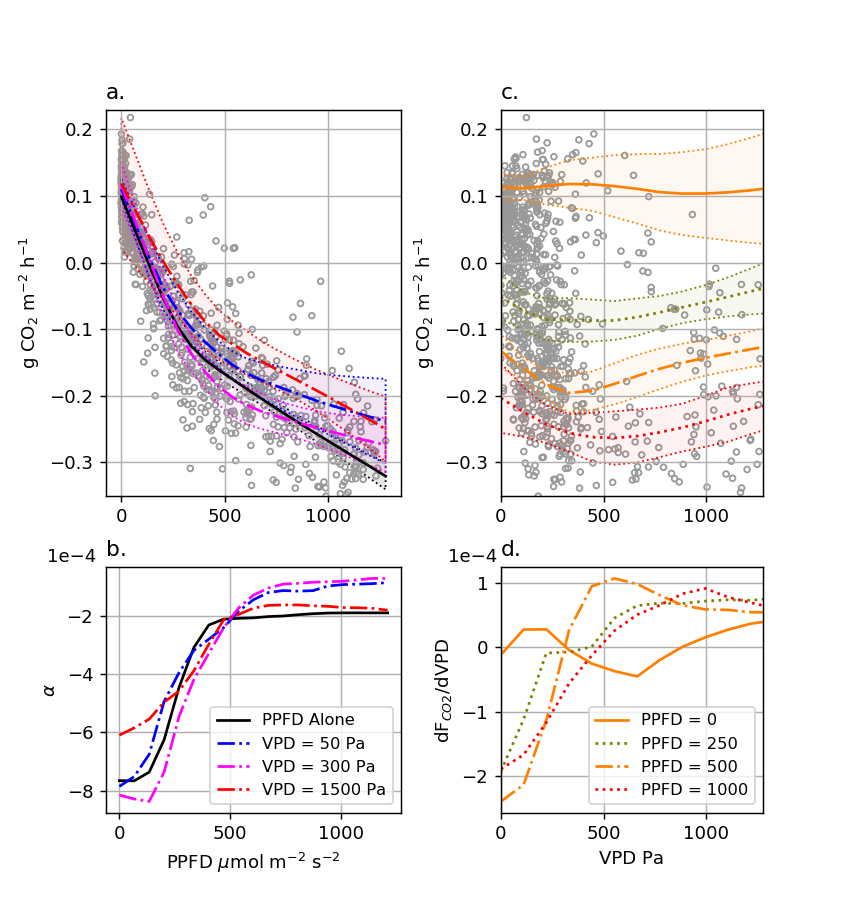

LightUse
-0.0007655705250431904 -0.00019062175761696843
Intercept
0.09898456093042374
[[3.70625682e-01 5.49143435e-01 5.00000000e+01]
 [3.70625682e-01 5.49143435e-01 3.00000000e+02]
 [3.70625682e-01 5.49143435e-01 1.50000000e+03]] ['Shrub', 'VWC', 'VPD']
Light Use
-0.0007847490619910049 -8.718480997876636e-05
Intercept
0.1104439381682396
Light Use
-0.0008361109971427353 -7.269515231936096e-05
Intercept
0.11611556725101471
Light Use
-0.0006092725504862704 -0.00016347317113125822
Intercept
0.11900816302908898
Light Use
-4.5036904952213026e-05 6.145268275139823e-05
Intercept
0.11317264358668327
Light Use
-0.00019253695113836952 7.639774647730409e-05
Intercept
-0.051526977527518274
Light Use
-0.00023962049246537565 0.00010748331405854757
Intercept
-0.13287019685565948
Light Use
-0.00018923655309347682 9.189237946337513e-05
Intercept
-0.20349187029361726


In [361]:
%matplotlib notebook
mult = {'fco2':(1e-6 * 12.0107 *3600),
        'ER':(1e-6 * 12.0107 *3600),
        'fch4':(1e-3 * 12.0107 *3600)}
line = '-'
colors = [[0,0,0]]
N=len(colors)
FirstRun = True
FirstRun = False
fco2.Model_Selection = 'PPFD_Avg'

differential='PPFD_Avg'
map_range=[T30[differential].min(),T30[differential].max()]
if FirstRun == True:
    Just = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,differential,N=N,
                         map_range=map_range
                        )
    Just.append([tarList_co2,means_co2,columns_co2,Data_co2])
else:
    tarList_co2,means_co2,columns_co2,Data_co2 = Just[0]
AllData=tarList_co2[0]
target = fco2
fig = plt.figure(figsize=(6.5,7))
ax1 = plt.subplot2grid((100, 100), (0, 0),rowspan=55,colspan=45)
ax2 = plt.subplot2grid((100, 100), (65, 0),rowspan=35,colspan=45)
ax3 = plt.subplot2grid((100, 100), (0, 60),rowspan=55,colspan=40)
ax4 = plt.subplot2grid((100, 100), (65, 60),rowspan=35,colspan=40)
j = 0
idx = []
ax = [ax1,ax2]
# colorz = []

for key,color in zip(AllData['key'].unique(),colors):
    AllData['Select']=0
    label = 'PPFD Alone'
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
#     Data[target.target] -= Data[target.target].iloc[0]
#     Data[target.target] *=-1
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=mult[target.target])
    tar = 'fco2'
    ax[1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*mult[target.target])[1:],
           linestyle = line,label = label,color = color)
    ax[1].axes.ticklabel_format(axis='x',style='sci')
    j += 1
    print('LightUse')
    print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
          np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])
    print('Intercept')
    print(Data[target.target].iloc[0]*mult[target.target])

fco2.Model_Selection = 'PPFD_Avg+VPD+VWC+Shrub'
N = 3
QV = 'VPD'
Mask = {'Shrub':[T30['Shrub'].mean() for n in range(N)],#
           'VWC':np.asanyarray([T30['VWC'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           QV:np.asanyarray([50,300,1500]),#T30[QV].quantile(.05),T30[QV].quantile(.95)]),
           }
differentials = ['PPFD_Avg','VPD']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]
# targets = [fco2,fco2]
# k = 0
SCENARIOS = []
xlbs = [' ${\mu}$mol m$^{-2}$ s$^{-2}$',' Pa']
map_range=map_ranges[0]
differential=differentials[0]
N=3
colors = [[0,0,1],[1,.0,1],[1,0,0]]
lines = ['-.','-.','-.']
target = fco2
xlb = xlbs[0]
# FirstRun == False
if FirstRun == True:
    CO21 = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,
         Mask=Mask,map_range=map_range)
    CO21.append([tarList_co2,means_co2,columns_co2,Data_co2])
else:
    tarList_co2,means_co2,columns_co2,Data_co2 = CO21[0]
    print(means_co2,columns_co2)
    
AllData=tarList_co2[0]
# colorz = []
if target == ER:
    val = 'ER'
else:
    val = 'fco2'
ax[0].scatter(target.RST.Master[differential],target.RST.Master[val]*mult[target.target],
          edgecolor=[.6,.6,.6],
          facecolor='None',s=10,label = 'Obs.')
cols = [aliases[col] for col in columns_co2]
Scenarios = pd.DataFrame(data=means_co2,columns=cols)
Scenarios = Scenarios.round(2)
# print(Scenarios)
SCENARIOS.append(Scenarios)
j = 0
for key,color,line in zip(AllData['key'].unique(),colors,lines):
    List = [color]
    List+=['white'for i in range(len(columns_co2))]
#     colorz.append(List)
    AllData['Select']=0
#     print(key)
    label = QV+' = '+str(int(Scenarios[QV].iloc[j]))+' Pa'
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
#     Data[target.target] -= Data[target.target].iloc[0]
#     Data[target.target] *= -1
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=mult[target.target],alpha=.05)
    tar = 'F$_{CO2}$'

    ax[1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*mult[target.target])[1:],
           linestyle = line,label = label,color = color)
#     print(label)
    j += 1
    print('Light Use')
    print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
          np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])

    print('Intercept')
    print(Data[target.target].iloc[0]*mult[target.target])
    
    
ax = [ax3,ax4]
# plt.show()

N = 4
QV = 'PPFD_Avg'
Mask = {'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(N)]),#
           'VWC':np.asanyarray([T30['VWC'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           QV:np.asanyarray([0,250,500,1000]),#T30[QV].quantile(.05),T30[QV].quantile(.95)]),
           }
SCENARIOS = []
# xlbs = [' ${\mu}$mol m$^{-2}$ s$^{-2}$',' Pa']
differential='VPD'
map_range = [T30[differential].min(),T30[differential].max()]
N=2
colors = [[1,.5,0],[.5,.5,0],[1,.5,0],[1,0,0]]
lines = ['-',':','-.',':']
target = fco2
xlb = xlbs[0]
if FirstRun == True:
    CO212 = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,
         Mask=Mask,map_range=map_range)
    CO212.append([tarList_co2,means_co2,columns_co2,Data_co2])
else:
    tarList_co2,means_co2,columns_co2,Data_co2 = CO212[0]
    
AllData=tarList_co2[0]
colorz = []
if target == ER:
    val = 'ER'
else:
    val = 'fco2'
cols = [aliases[col] for col in columns_co2]
Scenarios = pd.DataFrame(data=means_co2,columns=cols)
Scenarios = Scenarios.round(2)
# print(Scenarios)
SCENARIOS.append(Scenarios)
j = 0
ax[0].scatter(target.RST.Master[differential],target.RST.Master[val]*mult[target.target],
          edgecolor=[.6,.6,.6],
          facecolor='None',s=10,label = 'Obs.')
for key,color,line in zip(AllData['key'].unique(),colors,lines):
    List = [color]
    List+=['white'for i in range(len(columns_co2))]
    colorz.append(List)
    AllData['Select']=0
#     print(key)
    label = aliases[QV]+' = '+str(int(Scenarios[aliases[QV]].iloc[j]))
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=mult[target.target],alpha=.05)
    tar = 'F$_{CO2}$'

    ax[1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*mult[target.target])[1:],
           linestyle = line,label = label,color = color)
    j += 1
    print('Light Use')
    print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
          np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])

    print('Intercept')
    print(Data[target.target].iloc[0]*mult[target.target])
    
# ax3.legend(fontsize=9,loc=0)
ax3.set_ylim(-.36,.2)
ax3.grid()
ax3.set_xlim(0,T30['PPFD_Avg'].max())
# ax3.set_xlabel(aliases[differential]+' %')
ax3.set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax3.set_title('c.',loc='left')

ax4.ticklabel_format(axis='y',style='sci',scilimits = (0,0))
ax4.get_yaxis().get_offset_text().set_position((-0.2,-0.1))
ax4.grid()
ax4.set_xlim(0,T30['PPFD_Avg'].max())
ax4.set_ylabel('d'+tar+'/d'+aliases[differential])
ax4.set_xlabel(aliases[differential]+' Pa')
ax4.legend(fontsize=9,loc=0)
ax4.set_title('d.',loc='left')

ax2.legend(fontsize=9,loc=4)
ax1.set_title('a.',loc='left')
ax1.set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax1.grid()
ax2.set_ylabel('$\\alpha$')
ax2.ticklabel_format(axis='y',style='sci',scilimits = (0,0))
ax2.get_yaxis().get_offset_text().set_position((-0.2,-0.1))
ax2.set_title('b.',loc='left')
ax2.grid()
ax2.set_xlabel('PPFD ${\mu}$mol m$^{-2}$ s$^{-2}$')


ax1.set_ylim(-.35,.23)
ax3.set_ylim(-.35,.23)
        
# plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig5.png',dpi=300)


In [366]:
print(means_co2,columns_co2)

[array([326.7237617, 326.7237617, 326.7237617])
 array([0.37062568, 0.37062568, 0.37062568, 0.37062568])
 list([1000, 500, 250, 0])] ['VPD', 'Shrub', 'PPFD_Avg']


<IPython.core.display.Javascript object>


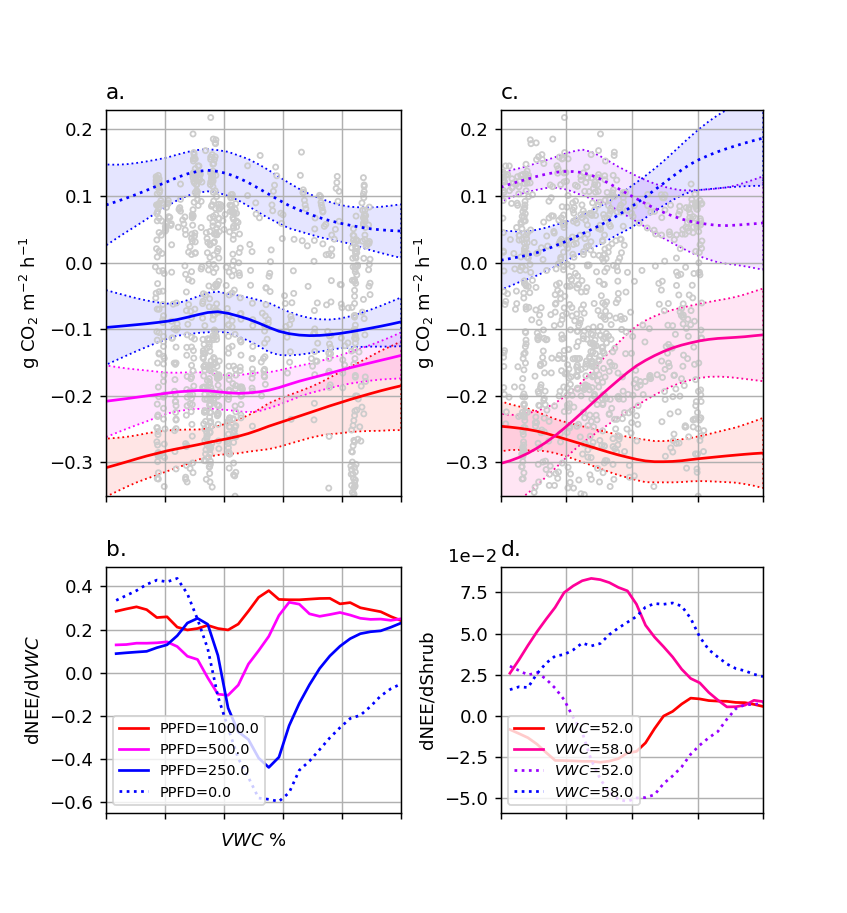

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib

In [399]:
FirstRun=True
FirstRun=False
target = fco2
if FirstRun == True:  
    CO22A = []

fig = plt.figure(figsize=(6.5,7))
ax1 = plt.subplot2grid((100, 100), (0, 0),rowspan=55,colspan=45)
ax2 = plt.subplot2grid((100, 100), (65, 0),rowspan=35,colspan=45,sharex=ax1)
ax3 = plt.subplot2grid((100, 100), (0, 60),rowspan=55,colspan=40)
ax4 = plt.subplot2grid((100, 100), (65, 60),rowspan=35,colspan=40,sharex=ax3)

fco2.Model_Selection = 'PPFD_Avg+VPD+VWC+Shrub'
colors = [[1,0,0],[1,0,.6],[.6,0,1],[0,0,1]]
lines = ['-','-',':',':']
N = 4
QV = 'VWC'
Mask = {'VWC':np.asanyarray([T30['VWC'].quantile(.1),T30['VWC'].quantile(.9),T30['VWC'].quantile(.1),T30['VWC'].quantile(.9)]),#
           'VPD':np.asanyarray([T30['VPD'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           'PPFD_Avg':[1000,1000,0,0],
           }
differentials = ['Shrub']
map_range = [0,1]
k = 0
SCENARIOS = []
xlbs = [' %',' %']
if FirstRun == True:
    CO22A = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,
                               differentials[0],N=N,Mask=Mask,map_range=map_range)
    CO22A.append([tarList_co2,means_co2,columns_co2,Data_co2])
i = 0
for k in range(1):
    differential = differentials[k]
    tarList_co2,means_co2,columns_co2,Data_co2 = CO22A[k]
    Scenarios = pd.DataFrame(data=means_co2,columns=columns_co2)
    Scenarios = Scenarios.reset_index(drop = True)
    AllData=tarList_co2[0]
    j = 0
    idx = []
    ax = [ax3,ax4]
    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        label = aliases[QV]+'='+str((Scenarios[QV].iloc[i]*100).round(0))
        List = [color]
        List+=['white'for p in range(len(columns_co2))]
        colorz.append(List)
        AllData['Select']=0
        for o,col in enumerate(columns_co2):
            AllData.loc[np.abs(AllData[col]-means_co2[key,o])<1e-4,'Select']+=1
        intt = 'CI'
        if k == 1:
            intt='PI'
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Data[differential]*=100
        Plot(ax[0],label,Data,differential,color,target.target,Interval = intt,
             linestyle=line,mult = mult[target.target])
        tar = 'F$_{CO2}$'
        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1
        i += 1
colors = [[1,0,0],[1,0,1],[0,0,1],[0,0,1]]
lines = ['-','-','-',':']
N = 4
QV = 'PPFD_Avg'
Mask = {'VPD':np.asanyarray([T30['VPD'].mean() for n in range(N)]),#
           'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           'PPFD_Avg':[1000,500,250,0],
           }
differentials = ['VWC']
map_range = [.5,.6]
k = 0
SCENARIOS = []
xlbs = [' %',' %']
if FirstRun == True:
    CO22B = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,'VWC',N=3,Mask=Mask,map_range=map_range)
    CO22B.append([tarList_co2,means_co2,columns_co2,Data_co2])
i = 0
for k in range(1):
    differential = differentials[k]
    tarList_co2,means_co2,columns_co2,Data_co2 = CO22B[k]
    Scenarios = pd.DataFrame(data=means_co2,columns=columns_co2)
    Scenarios = Scenarios.reset_index(drop = True)
    AllData=tarList_co2[0]
    target = fco2
    j = 0
    idx = []
    ax = [ax1,ax2]
    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List+=['white'for p in range(len(columns_co2))]
        AllData['Select']=0
        label = aliases[QV]+'='+str(Scenarios[QV].iloc[i].round(0))
        for o,col in enumerate(columns_co2):
            AllData.loc[np.abs(AllData[col]-means_co2[key,o])<1e-4,'Select']+=1
        intt = 'CI'
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Data[differential]*=100
        Plot(ax[0],label,Data,differential,color,target.target,Interval = intt,
             linestyle=line,mult = mult[target.target])
        tar = 'F$_{CO2}$'
        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,label = label,color = color)
        j += 1
        i += 1
    k+=1
ax1.set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax2.set_ylabel('dNEE/d'+aliases[differential])
ax1.scatter(target.RST.Master['VWC']*100,target.RST.Master[val]*mult[target.target],
          edgecolor=[.8,.8,.8],facecolor='None',s=8)
ax3.scatter(target.RST.Master['Shrub']*100,target.RST.Master[val]* mult[target.target],
          edgecolor=[.8,.8,.8],facecolor='None',s=8)
ax2.set_xlabel(aliases['VWC']+' %')
ax3.set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax2.set_ylabel('dNEE/d'+aliases['VWC'])
ax4.set_ylabel('dNEE/d'+aliases['Shrub'])

if val == 'fco2':
    ax[0].set_title('a.',loc='left')
    ax[1].set_title('b.',loc='left')
k+=1

ax2.legend(fontsize=8,loc=3)
ax4.legend(fontsize=8,loc=3)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.set_ylim(-.35,.23)
ax3.set_ylim(-.35,.23)
ax1.set_xlim(50,60)
ax2.set_xlim(50,60)
ax1.set_xticklabels([])
ax3.set_xticklabels([])
ax3.set_xlim(0,100)
ax4.set_xlim(0,100)
ax1.set_title('a.',loc='left')
ax4.set_title('b.',loc='left')
ax3.set_title('c.',loc='left')
ax4.set_title('d.',loc='left')
ax4.ticklabel_format(axis='y',style='sci',scilimits = (0,0))
ax4.get_yaxis().get_offset_text().set_position((-0.2,-0.1))
    
plt.tight_layout(pad = .35)
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig6.png',dpi=300)
   


In [391]:
# print(Data.shape)
# print(Data['VWC'])

90       0.000000
91       3.448276
92       6.896552
93      10.344828
94      13.793103
95      17.241379
96      20.689655
97      24.137931
98      27.586207
99      31.034483
100     34.482759
101     37.931034
102     41.379310
103     44.827586
104     48.275862
105     51.724138
106     55.172414
107     58.620690
108     62.068966
109     65.517241
110     68.965517
111     72.413793
112     75.862069
113     79.310345
114     82.758621
115     86.206897
116     89.655172
117     93.103448
118     96.551724
119    100.000000
Name: VWC, dtype: float64


FloatProgress(value=0.0, description='Running:', max=30.0)

(60, 5) (60,)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[3.87373565 7.22671319 0.28       0.        ]
 [3.87373565 7.22671319 0.03       0.56      ]
 [3.87373565 7.22671319 0.03       0.        ]] ['1', '2', '3'] ['$\\overline{U}$', 'T$_{s}$', 'OOB', 'Sedge']
  Scenario  $\overline{U}$  T$_{s}$   OOB  Sedge
1        1            3.87     7.23  0.28   0.00
2        2            3.87     7.23  0.03   0.56
3        3            3.87     7.23  0.03   0.00


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


FloatProgress(value=0.0, description='Running:', max=30.0)

(60, 5) (60,)
[[3.87373565 0.52       0.28       0.        ]
 [3.87373565 0.58       0.03       0.56      ]
 [3.87373565 0.54914343 0.03       0.        ]] ['1', '2', '3'] ['$\\overline{U}$', '$VWC$', 'OOB', 'Sedge']
  Scenario  $\overline{U}$  $VWC$   OOB  Sedge
1        1            3.87   0.52  0.28   0.00
2        2            3.87   0.58  0.03   0.56
3        3            3.87   0.55  0.03   0.00


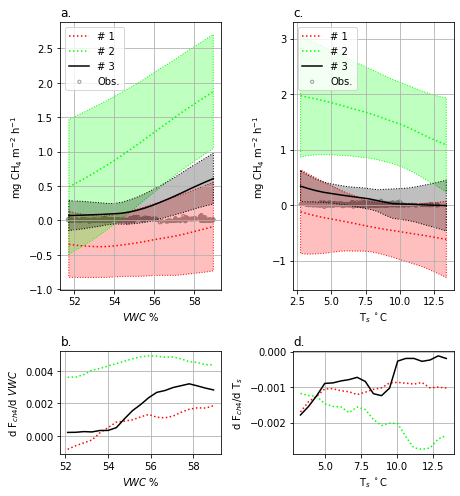

In [44]:
FirstRun=False
if FirstRun == True:  
    CH41 = []
fig = plt.figure(figsize=(6.5,7))
fch4.Model_Selection = 'wind_speed+Temp+VWC+Sedge+Out_of_Basin'

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

COLORS = [[[1,0,0],[0,1,0],[0,0,0]],#+['red','orange','green','blue'],
          [[1,0,0],[0,1,0],[0,0,0],[1,1,0]]]

LINES = [[':',':','-'],#,'-','-'],#+[':',':',':',':'],
         [':',':','-','-']]#,'-','-']]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
# M = 2
Masks = [
    {'wind_speed':[T30['wind_speed'].mean() for i in range(N)],
      'Temp':[T30['Temp'].mean() for i in range(N)],
      'Out_of_Basin':[.28,.03,.03],
      'Sedge':[.00,.56,.0],
     },
    
    {'wind_speed':[T30['wind_speed'].mean() for i in range(N)],
      'VWC':[.52,.58,T30['VWC'].mean()],# for i in range(N)],
      'Out_of_Basin':[.28,.03,.03],
      'Sedge':[.00,.56,.0],
#     {'wind_speed':[T30['wind_speed'].mean() for i in range(M)],
#       'VWC':[.52,.52,.58,.58],
#       'Out_of_Basin':[.27,.04,.27,.04],
#       'Sedge':[.01,.54,.01,.54],
     }
        ]
differentials = ['VWC','Temp']
map_ranges = [[T30[differentials[0]].min(),T30[differentials[0]].max()],
             [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fch4,fch4]
k = 0
SCENARIOS = []
xlbs = [' %',' $^\circ$C']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,map_ranges,
                                                                 differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4=MapJobs(target,differential,N=N,
             Mask=Mask,map_range=map_range)
        CH41.append([tarList_ch4,means_ch4,columns_ch4,Data_ch4])
    else:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4 = CH41[k]
    AllData=tarList_ch4[0]
#     print(tarList_ch4,means_ch4,columns_ch4,Data_ch4)
    j = 1
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
#     colorz = []
    val = 'fch4'
    if differential == 'VWC':
        conv = 100
    else:
        conv = 1
    ax[0].scatter(target.RST.Master[differential]*conv,target.RST.Master[val],
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_ch4))]
#         colorz.append(List)
        AllData['Select']=0
        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_ch4):
            AllData.loc[np.abs(AllData[col]-means_ch4[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        if differential=='VWC':
            Data[differential]*=100
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,
                  mult = mult[target.target])
        tar = 'F$_{ch4}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1
    cols = [aliases[col] for col in columns_ch4]
    print(means_ch4,idx,cols)
    Scenarios = pd.DataFrame(data=means_ch4,index=idx,columns=cols)
    # Scenarios['VPD'] = T30['VPD'].mean()
    Scenarios = Scenarios.round(2)
    # Scenarios['VPD'] = Scenarios['VPD'].astype(int)
    Scenarios['Scenario']=idx
    Scenarios = Scenarios[['Scenario']+cols]

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d '+tar+'/d '+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+xlb)
    ax[0].legend(fontsize=10,loc=2)

    ax[0].grid()
    ax[1].grid()
#     if val == 'fch4':
#     ax[0].set_ylim([-1.75,4])
#     elif val == 'fch4':
#         ax[0].set_ylim([0,1.2])
        
#     ax[0].set_xlim([T30[differential].min()-T30[differential].min()*.01,T30[differential].max()+T30[differential].max()*.01])

    if k == 0:
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
    k+=1
    
    print(Scenarios)
      

    SCENARIOS.append(Scenarios)

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig9.png',dpi=300)

FloatProgress(value=0.0, description='Running:', max=30.0)

(60, 5) (60,)
-0.12713911198079586 0.060707873199135065
Mean
0.16625565
-4.0684404
0.6351615
-0.121254824
-0.3026502
-8.015626
-0.11756047327071428 0.041431463323533535
Mean
0.17456387
-3.9581108
0.6535092
0.08478978
-0.30082244
-8.001011
-0.12037281319499003 0.01460619643330574
Mean
0.6175889
-3.7570646
1.5625616
0.45784834
-0.2920794
-7.9719777
  Scenario  Sedge  T$_{s}$  $VWC$  $\overline{U}$
1        1    0.0     7.23   0.51            3.87
2        2    0.0     7.23   0.55            3.87
3        3    0.0     7.23   0.59            3.87


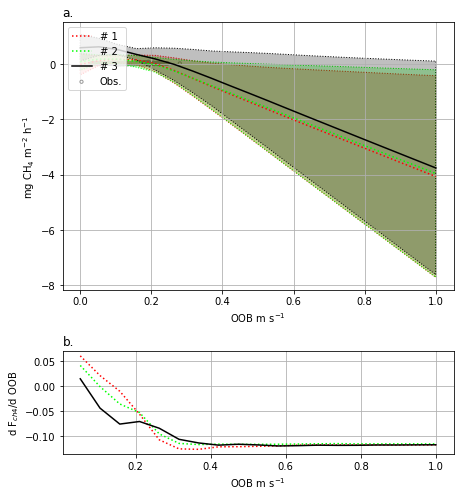

In [80]:
FirstRun=True
if FirstRun == True:  
    CH42 = []

fig = plt.figure(figsize=(6.5,7))

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2,colspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0),colspan=2)
# ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
# ax4 = plt.subplot2grid((3, 2), (2, 1))

COLORS = [[[1,0,0],[0,1,0],[0,0,0]],#+['red','orange','green','blue'],
#           ['red','green','black']
         ]
# 'red','green',
# 'red','green',

LINES = [[':',':','-'],#,'-','-'],#+[':',':',':',':'],
         [':',':','-']]#,'-','-']]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
Masks = [{#'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],
      'Sedge':[0,0,0],#T30['VWC'].quantile(.1) for i in range(N)],
      'Temp':[T30['Temp'].mean() for i in range(N)],
      'VWC':[.51,.55,.59],
      'wind_speed':[T30['wind_speed'].mean() for i in range(N)]
     },
#     {'VWC':[.52,.55,.58],#T30['VWC'].quantile(.1) for i in range(N)],
#       'Temp':[T30['Temp'].mean() for i in range(N)],
#       'Out_of_Basin':[0,0,.0],
#       'wind_speed':[T30['wind_speed'].mean() for i in range(N)]
#      },
        ]
differentials = ['Out_of_Basin']#,'PPFD_Avg']
map_ranges = [[0,1]]
#              [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fch4,fch4]
k = 0
SCENARIOS = []
# Ns=2
xlbs = [' m s$^{-1}$',' umol m$^{-2}$ s$^{-2}$']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,
map_ranges,differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4=MapJobs(target,differential,N=N,
             Mask=Mask,
                                 map_range=map_range
                                )
        CH42.append([tarList_ch4,means_ch4,columns_ch4,Data_ch4])
    else:
        tarList_ch4,means_ch4,columns_ch4,Data_ch4 = CH42[k]
    AllData=tarList_ch4[0]
#     target = fch4
    j = 1
#     print(means_ch4)
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
#     colorz = []
    if target == fch4:
        val = 'fch4'
    else:
        val = 'fch4'
    if differential=='VWC':
        m = 100
    else:
        m = 1
    ax[0].scatter(target.RST.Master[differential]*m,target.RST.Master[val]*1,
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_ch4))]
#         colorz.append(List)
        AllData['Select']=0

        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_ch4):
            AllData.loc[np.abs(AllData[col]-means_ch4[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        if differential=='VWC':
            Data[differential]*=100
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=mult[target.target])
        tar = 'F$_{ch4}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1

        print(np.min(Data[target.target].diff()/Data[differential].diff()),
              np.max(Data[target.target].diff()/Data[differential].diff()))
        print('Mean')
        print((Data['fch4']*mult[target.target]).max())
        print((Data['fch4']*mult[target.target]).min())
        
        print(((Data['fch4']+Data['PI'])*mult[target.target]).max())
        print(((Data['fch4']+Data['PI'])*mult[target.target]).min())
        print(((Data['fch4']-Data['PI'])*mult[target.target]).max())
        print(((Data['fch4']-Data['PI'])*mult[target.target]).min())

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d '+tar+'/d '+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+xlb)
    ax[0].legend(fontsize=10,loc=2)

    ax[0].grid()
    ax[1].grid()
    
#     ax[0].set_ylim([-1.75,4])
    if k == 0:
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
        
    k+=1
    try:

        cols = [aliases[col] for col in columns_ch4]
        Scenarios = pd.DataFrame(data=means_ch4,index=idx,columns=cols)
        # Scenarios['VPD'] = T30['VPD'].mean()
        Scenarios = Scenarios.round(2)
        # Scenarios['VPD'] = Scenarios['VPD'].astype(int)
        Scenarios['Scenario']=idx
        Scenarios = Scenarios[['Scenario']+cols]
        print(Scenarios)
    except:
        pass

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig10.png',dpi=300)

In [28]:
# # print(T30.loc[T30['PPFD_Avg']<10,differentials[1]].max())
# # Scenarios = Scenarios.reset_index(drop = True)
# print(Scenarios)
# # print(T30['PPFD_Avg'].mean())
# print(Scenarios[QV].iloc[i].round(0))
# # print(i)
# print(Data)

       PPFD_Avg         VPD       VWC     Shrub  key      fco2   Var_reg  \
40     1.757000  326.723762  0.549143  0.743099    2  2.258214  0.314534   
41    68.822421  326.723762  0.549143  0.743099    2  1.159863  0.202019   
42   135.887842  326.723762  0.549143  0.743099    2  0.083265  0.167790   
43   202.953263  326.723762  0.549143  0.743099    2 -0.933898  0.192580   
44   270.018684  326.723762  0.549143  0.743099    2 -1.813156  0.199459   
45   337.084105  326.723762  0.549143  0.743099    2 -2.557449  0.195781   
46   404.149526  326.723762  0.549143  0.743099    2 -3.182612  0.198890   
47   471.214947  326.723762  0.549143  0.743099    2 -3.607385  0.175105   
48   538.280368  326.723762  0.549143  0.743099    2 -3.933305  0.158095   
49   605.345789  326.723762  0.549143  0.743099    2 -4.203088  0.135911   
50   672.411211  326.723762  0.549143  0.743099    2 -4.427973  0.120645   
51   739.476632  326.723762  0.549143  0.743099    2 -4.639177  0.097754   
52   806.542

In [ ]:
print(Data)
plt.scatter(T30['VPD'],T30['AirTC_Avg'])

0.34669492
-0.086799696
-7.987583
-8.016003


FloatProgress(value=0.0, description='Running:', max=30.0)

(60, 5) (60,)
Mean
2.4466226
0.44848573
5.735318
2.9536283
-0.52764094
-2.056657
Mean
-1.7477344
-3.246455
1.9136959
-0.9002377
-4.597681
-5.5926723
Mean
-4.5273523
-5.357421
-0.5197079
-2.557127
-7.643249
-8.8391905
  Scenario     PPFD  $VWC$  OOB     VPD
1        1     0.00   0.55  0.0  326.72
2        2   333.28   0.55  0.0  326.72
3        3  1000.00   0.55  0.0  326.72


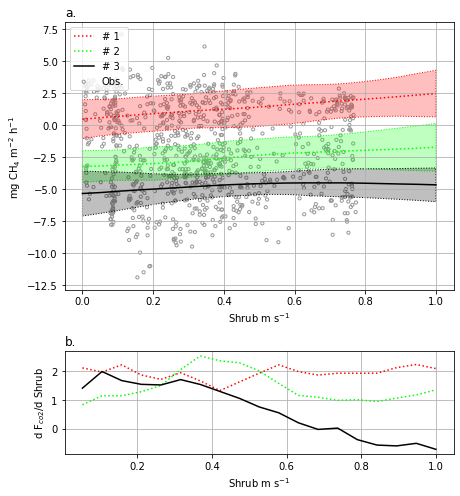

In [435]:
# fco2.Model_Selection='PPFD_Avg+VPD+VWC+Shrub+Out_of_Basin'
FirstRun=False
if FirstRun == True:  
    CO22 = []

fig = plt.figure(figsize=(6.5,7))

ax1 = plt.subplot2grid((3, 2), (0, 0),rowspan=2,colspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0),colspan=2)
# ax3 = plt.subplot2grid((3, 2), (0, 1),rowspan=2)
# ax4 = plt.subplot2grid((3, 2), (2, 1))

COLORS = [[[1,0,0],[0,1,0],[0,0,0]],#+['red','orange','green','blue'],
#           ['red','green','black']
         ]
# 'red','green',
# 'red','green',

LINES = [[':',':','-'],#,'-','-'],#+[':',':',':',':'],
         [':',':','-']]#,'-','-']]
Ns=[]
for colors in COLORS:
    Ns.append(len(colors))
N = 3
Masks = [{#'PPFD_Avg':[T30['PPFD_Avg'].mean() for i in range(N)],
      'PPFD_Avg':[0,T30['PPFD_Avg'].mean(),1000],#T30['VWC'].quantile(.1) for i in range(N)],
      'VWC':[T30['VWC'].mean() for i in range(N)],
      'Out_of_Basin':[0 for i in range(N)],
      'VPD':[T30['VPD'].mean() for i in range(N)]
     },
#     {'VWC':[.52,.55,.58],#T30['VWC'].quantile(.1) for i in range(N)],
#       'Temp':[T30['Temp'].mean() for i in range(N)],
#       'Out_of_Basin':[0,0,.0],
#       'wind_speed':[T30['wind_speed'].mean() for i in range(N)]
#      },
        ]
differentials = ['Shrub']#,'PPFD_Avg']
map_ranges = [[0,1]]
#              [T30[differentials[1]].min(),T30[differentials[1]].max()]]
targets = [fco2,fco2]
k = 0
SCENARIOS = []
xlbs = [' m s$^{-1}$',' umol m$^{-2}$ s$^{-2}$']
for Mask,map_range,differential,N,colors,lines,target,xlb in zip(Masks,
map_ranges,differentials,Ns,COLORS,LINES,targets,xlbs):
    if FirstRun == True:
        tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,
             Mask=Mask,
                                 map_range=map_range
                                )
        CO22.append([tarList_co2,means_co2,columns_co2,Data_co2])
    else:
        tarList_co2,means_co2,columns_co2,Data_co2 = CO22[k]
    AllData=tarList_co2[0]
#     target = fco2
    j = 1
#     print(means_co2)
    idx = []
    if k == 0:
        ax = [ax1,ax2]#,ax3]
    else:
        ax = [ax3,ax4]
#     colorz = []
    if target == fco2:
        val = 'fco2'
    else:
        val = 'fco2'
    if differential=='VWC':
        m = 100
    else:
        m = 1
    ax[0].scatter(target.RST.Master[differential]*m,target.RST.Master[val]*mult[target.target],
                  edgecolor=[.6,.6,.6],
                  facecolor='None',s=10,label = 'Obs.')

    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List = [color]
        List+=['white'for i in range(len(columns_co2))]
#         colorz.append(List)
        AllData['Select']=0

        label = '# '+str(j)
        idx.append(str(j))
        for i,col in enumerate(columns_co2):
            AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        if differential=='VWC':
            Data[differential]*=100
        Plot(ax[0],label,
             Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=mult[target.target])
        tar = 'F$_{co2}$'

        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1

#         print(np.min(Data[target.target].diff()/Data[differential].diff()),
#               np.max(Data[target.target].diff()/Data[differential].diff()))


        print('Mean')
        print((Data['fco2']*mult[target.target]).max())
        print((Data['fco2']*mult[target.target]).min())
        
        print(((Data['fco2']+Data['PI'])*mult[target.target]).max())
        print(((Data['fco2']+Data['PI'])*mult[target.target]).min())
        print(((Data['fco2']-Data['PI'])*mult[target.target]).max())
        print(((Data['fco2']-Data['PI'])*mult[target.target]).min())

    ax[0].set_xlabel(aliases[differential]+xlb)
    ax[0].set_ylabel('mg CH$_4$ m$^{-2}$ h$^{-1}$')
    ax[1].set_ylabel('d '+tar+'/d '+aliases[differential])
    ax[1].set_xlabel(aliases[differential]+xlb)
    ax[0].legend(fontsize=10,loc=2)

    ax[0].grid()
    ax[1].grid()
    
#     ax[0].set_ylim([-1.75,4])
    if k == 0:
        ax[0].set_title('a.',loc='left')
        ax[1].set_title('b.',loc='left')
    else:
        ax[0].set_title('c.',loc='left')
        ax[1].set_title('d.',loc='left')
        
        
    k+=1
    try:

        cols = [aliases[col] for col in columns_co2]
        Scenarios = pd.DataFrame(data=means_co2,index=idx,columns=cols)
        # Scenarios['VPD'] = T30['VPD'].mean()
        Scenarios = Scenarios.round(2)
        # Scenarios['VPD'] = Scenarios['VPD'].astype(int)
        Scenarios['Scenario']=idx
        Scenarios = Scenarios[['Scenario']+cols]
        print(Scenarios)
    except:
        pass

plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig10.png',dpi=300)

In [ ]:
print(T30['Out_of_Basin'].min(),T30['Sedge'].min())
print(T30['Out_of_Basin'].max(),T30['Sedge'].max())

In [ ]:
fco2.Project(Projector = None,Model = None)
# fco2.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])


y_pred = reg.predict(fco2.RST.Data[fco2.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))
print(metrics.r2_score(fco2.RST.Data[fco2.params['target']],y_pred))
y_pred2 =  reg.predict(fco2.RST.Data[fco2.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fco2.RST.Data['y_pred2']=y_pred2
plt.figure()
Var = 'Sedge'
Var = 'PPFD_Avg'
plt.scatter(fco2.RST.Data[Var],fco2.RST.Data['y_pred2'])


# import CART_Backend as Tree

# tree = Tree.Trees(fco2.RST.Data,'fco2',params['Inputs'])
# tree.Validate(kind='Tree',N_Max=15,step_size=1,ax=ax,iteration=15,min_samples_leaf=10)


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
print(fco2.params['Inputs'])
forest.fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])

y_pred = forest.predict(fco2.RST.Data[fco2.params['Inputs']])
y_pred3=forest.predict(fco2.RST.Data[fco2.params['Inputs']])
fco2.RST.Data['y_pred3']=y_pred3
plt.scatter(fco2.RST.Data[Var],fco2.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))
print(metrics.r2_score(fco2.RST.Data[fco2.params['target']],y_pred))

In [ ]:
fch4.Project(Projector = None,Model = None)
# fch4.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fch4.RST.Data[fch4.params['Inputs']],fch4.RST.Data[fch4.params['target']])


y_pred = reg.predict(fch4.RST.Data[fch4.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fch4.RST.Data[fch4.params['target']]))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))
y_pred2 =  reg.predict(fch4.RST.Data[fch4.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fch4.RST.Data['y_pred2']=y_pred2
plt.figure()
Var = 'Sedge'
# Var = 'PPFD_Avg'
plt.scatter(fch4.RST.Data[Var],fch4.RST.Data['y_pred2'])


# import CART_Backend as Tree

# tree = Tree.Trees(fch4.RST.Data,'fch4',params['Inputs'])
# tree.Validate(kind='Tree',N_Max=15,step_size=1,ax=ax,iteration=15,min_samples_leaf=10)


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
print(fch4.params['Inputs'])
forest.fit(fch4.RST.Data[fch4.params['Inputs']],fch4.RST.Data[fch4.params['target']])

y_pred = forest.predict(fch4.RST.Data[fch4.params['Inputs']])
y_pred3=forest.predict(fch4.RST.Data[fch4.params['Inputs']])
fch4.RST.Data['y_pred3']=y_pred3
plt.scatter(fch4.RST.Data[Var],fch4.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fch4.RST.Data[fch4.params['target']]))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))

Mean ER:
ER        2.422141
ER_est    2.309652
ER2       2.481975
ER3       3.159337
dtype: float64

R2 Score:
ER_est:  0.33098846151811157 ER2:  0.2345056681116756 ER3:  0.35541595170478946

MSE:
ER_est:  0.7628626134226478 ER2:  0.8160194624040037 ER3:  0.7488059802374896
GPP     4.474019
GPP2    4.436009
GPP3    5.050337
dtype: float64
NEE       -2.051878
NEE_est   -1.954349
NEE2      -1.959732
NEE3      -1.891001
dtype: float64
921 921 1.4071661237785016
(921, 436)
NEE_est:  0.9037334081481847 NEE2:  0.7944770282380469 NEE3:  0.7824590377021368
NEE_est:  1.0484927824277708 NEE2:  1.5319967091464903 NEE3:  1.5761522618694819


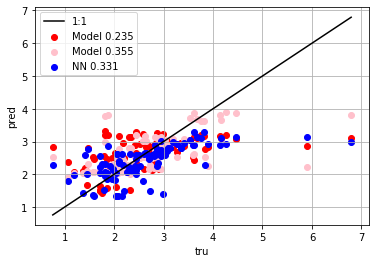

In [699]:

def P_func(PPFD,MQY,PM):
    cv =.7
    return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))
Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_est','ER','AirTC_Avg']].dropna()


# print(T30.loc[T30['PPFD_Avg']<10,['Temp','fco2']].drop)
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 45.9262144,0.5875255,2.7508822))
popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['fco2'])#,p0=( 4.59262144,0.5875255,0.27508822))

#p0=( 74.59262144,0.8875255,2.27508822)
# print(metrics.r2_score(Dark['fco2'],R_func2(Dark['Temp'],*popt_r2)))

plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),3)))
plt.scatter(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2),c='pink',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)),3))
           )
Dark['ER3'] = (R_func2(Dark['AirTC_Avg'],*popt_r2))
plt.scatter(Dark['fco2'],Dark['ER_est'],c='blue',
            label='NN '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_est']),3)))
# plt.colorbar()
plt.plot([Dark['fco2'].min(),Dark['fco2'].max()],[Dark['fco2'].min(),Dark['fco2'].max()],
         label='1:1',color='black')
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()

# plt.xlim(0,1)
# plt.ylim(0,1)
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)
T30['ER3'] = R_func2(T30['AirTC_Avg'],*popt_r2)


P = T30[T30['PPFD_Avg']>=10]
P = P[['fco2','ER2','ER3','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER2']),p0=(.01,10))
popt_p3, pcov3 = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER3']),p0=(.01,10))
# T30['GPP2'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
T30['GPP2'] = P_func(T30['PPFD_Avg'],*popt_p)
T30['GPP3'] = P_func(T30['PPFD_Avg'],*popt_p3)
T30['NEE2'] = T30['ER2']-T30['GPP2']
T30['NEE3'] = T30['ER3']-T30['GPP3']


Temp = T30.loc[np.isnan(T30['fco2'])==False]
print('Mean ER:')
print(Temp[['ER','ER_est','ER2','ER3']].mean()*mult['ER'])
# print(Dark['fco2'].mean())
print()
print('R2 Score:')
print('ER_est: ',metrics.r2_score(Dark['fco2'],Dark['ER_est']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),
     'ER3: ',metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)))
print()
print('MSE:')
print('ER_est: ',metrics.mean_squared_error(Dark['fco2'],Dark['ER_est'])**.5,
     'ER2: ',metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5,
     'ER3: ',metrics.mean_squared_error(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5)
# print(Temp[['GPP','GPP2','GPP3']].mean()*mult['ER'])
# print(Temp[['NEE','NEE_est','NEE2','NEE3']].mean()*mult['ER'])
# print(Temp['ER'].count(),T30['fco2'].count(),T30['ER'].count()/T30['fco2'].count())
# print(Temp.shape)
# TempNEE = Temp[['fco2','NEE','NEE_est','NEE2','NEE3']].dropna()
# print('NEE_est: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE_est']),
#      'NEE2: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE2']),
#      'NEE3: ',metrics.r2_score(TempNEE['fco2'],TempNEE['NEE3']))
# print('NEE_est: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE_est'])**.5,
#      'NEE2: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE2'])**.5,
#      'NEE3: ',metrics.mean_squared_error(TempNEE['fco2'],TempNEE['NEE3'])**.5)

Text(0, 0.5, 'Estimate')

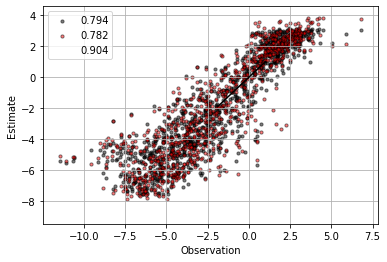

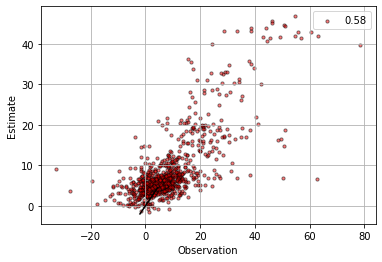

In [700]:
plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NEE2','NEE3','NEE_est','fco2']].dropna()
plt.plot([-1.9,1],[-1.9,1],color='black')
plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fco2'],T30['NEE_est'],c='red',edgecolor='black',alpha=0,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
# plt.ylim(-1.9,1)
# plt.xlim(-1.9,1)

plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NME_est','fch4']].dropna()
plt.plot([-2,4.5],[-2,4.5],color='black')
# plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
#            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
# plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
#            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fch4']*1e3,T30['NME_est']*1e3,c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fch4']*1e3,Temp['NME_est']*1e3),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
# plt.ylim(-1.9,1)
# plt.xlim(-1.9,1)

